# This Week’s Overview


In this practical we're going to expand our understanding of how to use `GeoPandas` as part of an analysis, and of how to implement different types of spatial and non-spatial joins in Python using the tools to-hand. You'll notice that the number of libraries that we need to do our work has been expanding since last week. You will have to finish 5 tasks:

- Load shapefile (using `geopandas`) and raster data (using `georasters` and `GDAL`).
- Non-spatial join - Some DataFrame operation such as 'join','append',’merge’ you learned in last term will be used.
- Spatial join - using python  - find points in polygons, convert raster to points and find points in polygons
- Overlaying raster and vector data type.
- Visualise spatial data using `geopandas`.


## Learning Outcomes

By the end of this practical you should have:
- Enhanced your skills of data processing - spatial and non-spatial join
- A better understanding of raster and vector data type in practices

## Get prepared
(always remember) The first thing we need to do is setup our working environment. Run the scripts below to import the relevant libraries.

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
# Make sure output is into notebook
%matplotlib inline
import matplotlib.pyplot as plt

import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import urllib
import zipfile
import re  #regex
import os

import shapely
from shapely.geometry import Point

import random 
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import georasters as gr

## Downloading data

Let's start by (re)loading both the AirBnB and the LSOA data, together with the NS-SeC data. This will give us the tools with which to test our understanding of data linking _and_ allow us to do some simple, but hopefully interesting, analyses. To try to reduce confusion, I've provided a way to automate the downloading of the data in the answers:

**Save the "LDN-LSOAs" and "Airbnb listings" data in your local directory, as we will use them in following weeks, and I won't upload these data on KEATs page repeatly.**

In [5]:
# Create the data dir if it doesn't exist
if os.path.isdir('data') is not True:
    print("Creating 'data' directory...")
    os.mkdir('data')

# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/LDN-LSOAs.zip?raw=true'
path = os.path.join("data","LDN-LSOAs.zip")

# Download
r    = urllib.request.urlretrieve(url, path)

# Unzip it into the data folder
z    = zipfile.ZipFile(path)
m    = z.extractall("data")

Creating 'data' directory...


In [7]:
# Configure the next download for NS-SeC data
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/NSSHRP_UNIT_URESPOP.zip?raw=true'
path = os.path.join("data","NSSHRP_UNIT_URESPOP.zip")

# Download but don't unzip it
r    = urllib.request.urlretrieve(url, path)

In [7]:
# Configure the next download -- notice 
# that you will need to visit InsideAirBnB
# in order to check that the data hasn't been
# updated from 2019/11/05.
url  = 'http://data.insideairbnb.com/united-kingdom/england/london/2019-11-05/data/listings.csv.gz'
path = os.path.join("data","listings.csv.gz")

# Download but don't unzip it
r    = urllib.request.urlretrieve(url, path)

The raster data you are going to play with is modelled air quality data available on London Datastore (modelled by King's Environmental research team!). Estimates of key pollutants (NOx, PM10, PM2.5 and CO2) are included for the base year 2013 and projected forward to 2020, 2025, and 2030. 

The LAEI (London Atmospheric Emissions Inventory) area covers the 32 London Boroughs and the City of London and up to the M25 motorway. You can find full data sets of air quality from [here](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013/resource/725450b0-a25c-4dc7-af30-c67054a676a3). 

To save you some time and also memory space of your computer, we have selected a small data set for your practice.

In [8]:
# Configure the next download -- air quality data 
# we have prepared a smaller size raster data for you.
url  = 'https://github.com/daisy8738/sp/raw/master/Met2013_PM25.zip'
path = os.path.join("data","PM25.zip")

# Download the data
r    = urllib.request.urlretrieve(url, path)

# unzip it into the data folder
z    = zipfile.ZipFile(path)
m    = z.extractall("data")

**Ok, you have downloaded all data sets!** The next step is to load the data sets and get yourself familiar with the relevant packages. 

### Loading AirBnB Data

Here is all the code to load the AirBnB data into a GeoDataFrame called `sdf` (spatial sample  dataframe):

In [4]:
# what format of data you are reading into the dataframe?
df       = pd.read_csv(os.path.join('data','airbnb_listings.csv'))
sample   = df.sample(frac=0.1)
geometry = [Point(xy) for xy in zip(sample.longitude, sample.latitude)]
crs      = {'init': 'epsg:4326'} # What projection is this lat/long? please google it
sdf      = gpd.GeoDataFrame(sample, crs=crs, geometry=geometry)
sdf      = sdf.to_crs({'init': 'epsg:27700'}) # Reproject into OSGB1936 with epsg value 27700

# Check the output for specific variables
sdf.head(3)[['id','host_id','neighbourhood','price','geometry']]

,id,host_id,neighbourhood,price,geometry
70599,36036122,64163865,City of Westminster,"$1,000.00",POINT (529109.222 178552.885)
9476,7278971,38112105,LB of Haringey,$27.00,POINT (532794.984 188006.374)
19428,13574341,78296828,RB of Kensington and Chelsea,$160.00,POINT (525071.968 180503.854)


**Now go to check the directory of your ipython-notebook file, a folder called 'data' is then there**

### Loading the LSOA Shapefile

Here is all of the code to load the LDN-LSOA shapefile, preparing the geopandas data frame for us to work with!

In [27]:
lsoas = gpd.read_file(os.path.join('data','LDN-LSOAs.shp'))
lsoas.sample(3)

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry
1921,E01001969,Haringey 001A,Haringey 001A,1922,"145,541.4228","2,201.5003","POLYGON ((530858.424 191295.128, 530856.817 19..."
1619,E01001652,Greenwich 019D,Greenwich 019D,1620,"263,543.6720","3,080.1734","POLYGON ((540865.497 177342.378, 540892.434 17..."
349,E01000354,Bexley 011B,Bexley 011B,350,"205,102.8745","3,175.9447","POLYGON ((548455.029 176903.163, 548563.025 17..."


### Loading the NS-SeC Data

Let's pull together everything we learned last term about what data we need to keep from the NS-SeC data file with everything we learned _this_ term with how to load data directly from a Zip file without the need to unzip it! 

Also, when you get to the end of this code block take a look at the first three columns and see if there's anything that look like it might match what we have in the `lsoas` geo-data.

In [9]:
z = zipfile.ZipFile(os.path.join('data','NSSHRP_UNIT_URESPOP.zip'))

nssec = pd.read_csv(z.open('Data_NSSHRP_UNIT_URESPOP.csv'), skiprows=[1])

# Check the output
# nssec.head(3)
# If we find this column, this deletes it
if np.where(nssec.columns.values=='Unnamed: 15')[0]:
    del nssec['Unnamed: 15']
if np.where(nssec.columns.values=='GEO_TYPE')[0]:
    del nssec['GEO_TYPE']
if np.where(nssec.columns.values=='GEO_TYP2')[0]:
    del nssec['GEO_TYP2']

# Initialise column names
colnames = ['CDU','GeoCode','GeoLabel','Total']
# And append the remainder of groups to columns
for i in range(1,9):
    colnames.append('Group' + str(i))
colnames.append('NC')
nssec.columns = colnames

# Check the output
nssec.head(3)

,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
0,18373,95AA01S1,Aldergrove_1,982,98,464,234,35,80,39,25,0,nan
1,18374,95AA01S2,Aldergrove_2,1814,256,417,170,446,162,156,156,47,nan
2,18375,95AA01S3,Aldergrove_3,1494,226,399,176,294,86,114,159,30,nan


### Loading the Air Quality (PM 2.5) data - have a go with raster file

GeoRasters package provides a fast and flexible tool to work with GIS raster files. It provides the GeoRaster class, which makes working with rasters quite transparent and easy. In a way it tries to do for raster what GeoPandas does for geometries.

We will first have a go with Georasters, as it allows a quick visualisation of raster data.

If very unfortunately, Package georasters does not work with you as it clashes with other dependencies, you can go to the very end of this practical, there gives another solution of using raster data by GDAL.

We are going to read .asc file. The ESRI ASCII raster format can be used to transfer information to or from other cell-based or raster systems. When an existing raster is output to an ESRI ASCII format raster, the file will begin with header information that defines the properties of the raster such as the cell size, the number of rows and columns, and the coordinates of the origin of the raster. The header information is followed by cell value information specified in space-delimited row-major order, with each row seperated by a carraige return.

In [10]:
#import the airqality file just downloaded from your local folder
rasterpath = os.path.join('data','2013_Met2013_LAEI2013_PM25.asc')

# Load raster data by calling georasters
rasterdata = gr.from_file(rasterpath)

In [14]:
# Plot data
plt.rcParams["figure.figsize"] = (12,8)
rasterdata.plot(cmap = 'gist_earth')
plt.savefig('output/pm25.png')

In [12]:
# what's the type of rasterdata
type(rasterdata)

georasters.georasters.GeoRaster

In [13]:
# Get some stats
print('average value of PM2.5 is %f' %rasterdata.mean())
print('min value of PM2.5 is %f' %rasterdata.min())
print('summed value of PM2.5 is %f' %rasterdata.sum())
print('standard deviation of PM2.5 is %f' %rasterdata.std())

average value of PM2.5 is 15.276280
min value of PM2.5 is 14.031460
summed value of PM2.5 is 89464432.000000
standard deviation of PM2.5 is 0.876288


#### Challenge 1 (Optional)
Could you find how many rows and columns in the raster file? 

**Hint**: now the rasterdata is like an array. how do you find the dimensions of an array?

In [15]:
# your code here 
print(rasterdata.shape)

(2556, 3027)


In [16]:
#Get the coordinates in the raster file
(xmin, xsize, x, ymax, y, ysize) = rasterdata.geot

# can you calculate the boundary of aboved plotted raster file? 
# you already know xmin, then what is the xmax?
xmax = xmin + xsize*rasterdata.shape[1]
# get the value for xmax
print (xmax)

561990.0


In [17]:
# you already know ymax, then what is the ymin?
ymin = ymax + ysize*rasterdata.shape[0]
# get the value for ymin
print (ymin)

152330.0


#### Challenge 2
You got the (xmin, ymin) and (xmax,ymax), could you transform the ($x,y$) in 2-d space to latitude and longtitude?

**Hint**: check practical 2 - in this case, you need to project **from epsg 27700 to epsg 4326**.

In [18]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:27700')
outProj = Proj(init='epsg:4326')
lon_min,lat_min = transform(inProj,outProj,xmin,ymin)
lon_max,lat_max = transform(inProj,outProj,xmax,ymax)
print (lon_min,lat_min,lon_max,lat_max)

-0.5474336655896453 51.26111317105572 0.34300883908817115 51.706406177697836


Folium is actually quite a useful tool. we have used it in Practical 1 and 2, we can also overlap an image on map. Folium works with image file - tiff. So before we do mapping, lets convert the .asc file to tiff file (tiff is like an image), which can be easily done by Georasters.

In [19]:
rasterdata.to_tiff('data/pm25_tiff')

In [36]:
# call folium to realize the interactive map
import folium
from folium import plugins
from matplotlib.pyplot import imread

# boundary of the image on the map
min_lon = lon_min
max_lon = lon_max
min_lat = lat_min
max_lat = lat_max
# create the map
map = folium.Map(location=[51.5113, -0.1160], tiles='Stamen Terrain', zoom_start = 10)

# read in png file to numpy array
data = imread('data/pm25_tiff.tif')

# Overlay the image
map.add_child(folium.raster_layers.ImageOverlay(data, cmap = 'gist_earth', opacity=0.8, bounds =[[min_lat, min_lon], [max_lat, max_lon]]))
map
# or you can simply call 'map' for visualization without saving it

**Georasters can also convert raster file to pandas dataframe. **

In [20]:
# Convert to Pandas DataFrame
raster_df = rasterdata.to_pandas()

In [21]:
raster_df.head(3)

,row,col,value,x,y
0,0,881,14.5353,"519,070.0000","203,450.0000"
1,0,882,14.5129,"519,090.0000","203,450.0000"
2,0,883,14.5110,"519,110.0000","203,450.0000"


**What does x,y,value mean here? Is that easier to get boundary from raster_df?**

In [22]:
print('xmin of rasterdata is %f' %raster_df.x.min())
print('xmax of rasterdata is %f' %raster_df.x.max())
print('ymin of rasterdata is %f' %raster_df.y.min())
print('ymax of rasterdata is %f' %raster_df.y.max())

print('the avergae value of PM2.5 in the measured area is %f' %raster_df.value.mean())

xmin of rasterdata is 501450.000000
xmax of rasterdata is 561970.000000
ymin of rasterdata is 152350.000000
ymax of rasterdata is 203450.000000
the avergae value of PM2.5 in the measured area is 15.276278


## Joining Data by Key

This is the most common way to join data (spatial or not) together: we have a unique id in one dataset and we match it to the _same_ unique id in a different data set. You should have known several types of join very well, but lets have another review:

1. Inner join: this will keep only the rows that have matching unique ids in both data sets, so any unique id that doesn't match will be discarded.
2. Outer join: this will keep all rows in both data sets, regardless of whether or not there is a match in the other data set.
3. Left join: all rows in the 'left' data set will be kept, regardless of whether or not there is a match in the 'right' data set.
4. Right join: reverse of a left join.

Left and right joins are a matter of preference: there is no real difference between them, it just depends on which data set you think of as being 'first' (i.e. to the _left_ in the join).

**_Note:_** this may seem fairly straightforward so far ("A whole practical on four types of joins???"), but you are probably making several unconscious assumptions: 1) you are assuming that each key or location is unique; 2) that the data set is not so large that the structure of the index matters; 3) that you are not joining based on multiple simultaneous conditions (e.g. within this area _and_ of this type)... We're only going to scrape the surface here, but you should be aware the topic of how to store, manage, and link data is incredibly complex: in database design we talk of the importance of complying with the five normal forms to manage data integrity, and then we violate them to improve performance!

There is, unfortunately, one bit of ugliness that we have to grapple with and it ties back to ideas of inheritance: **`merge` is a _pandas_ function and pandas doesn't know about _geopandas_.** So if we naively use pandas' merge function on a spatial data set then we get back a pandas dataframe. If, instead, we use the geopandas dataframe then we'll get back a geopandas dataframe. Again, this is a question of judgement -- the pandas `merge` is a little easier to read and gives us some more flexiblity, but with more hoops to jump through aftwards... Use whichever makes the most sense to you.

#### Method 1: Pandas Merge

Although I've been unable to reproduce what happened while I was developing the practical, if you find that you are no longer working with a GeoPandas object after a merge or similar operation, then it is fairly easy to convert between Pandas and GeoPandas by simply passing the dataframe to the GeoPandas constructor along with the projection and geometry fields. That said, this seems to work nicely and is equivalent to Method 2 (you don't need to run both blocks):

In [23]:
shpdf = pd.merge(lsoas, nssec, left_on='lsoa11cd', right_on='GeoCode', how='left')
print("Merged df is of type: " + str(type(shpdf)))

Merged df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


#### Method 2: Geopandas' Merge

This method is more direct, but it's not necessarily immediately clear what's going on because now `lsoas` is _implicitly_ the _left_ part of the join, not _explicitly_. Plus, if you were to reverse the order (so: `nssec.merge(lsoas...)`) then the result would no longer be a GeoDataFrame because you'd be using pandas' merge function, not geopandas'! Confusing, right?

In [24]:
shpdf = lsoas.merge(nssec, left_on='lsoa11cd', right_on='GeoCode')
print("Shape df is of type: " + str(type(shpdf)))

Shape df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


You may find the types of output are identical from both methods! 

In [25]:
print("lsoas has {0} rows, {1} columns".format(lsoas.shape[0], lsoas.shape[1]))
print("nssec has {0} rows, {1} columns".format(nssec.shape[0], nssec.shape[1]))
print("shpdf has {0} rows, {1} columns".format(shpdf.shape[0], shpdf.shape[1]))
shpdf.sample(3)

lsoas has 6 rows, 6 columns
nssec has 42619 rows, 13 columns
shpdf has 6 rows, 19 columns


,objectid,lsoa11cd,lsoa11nmw,st_areasha,st_lengths,geometry,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
2,3,E01000003,City of London 001C,"59,054.0131","1,224.7709","POLYGON ((532105.312 182010.574, 532104.872 18...",19265,E01000003,City of London 001C,1250,333,394,142,89,59,89,60,49,35.0000
0,1,E01000001,City of London 001A,"129,865.3376","2,635.7814","POLYGON ((532095.563 181577.351, 532095.125 18...",19263,E01000001,City of London 001A,1465,687,511,90,94,17,13,7,10,36.0000
5,31922,E01032740,City of London 001G,"637,236.5466","4,416.8286","POLYGON ((531626.061 180803.860, 531624.051 18...",51184,E01032740,City of London 001G,1049,498,304,70,62,23,10,3,6,73.0000


It's worth taking a few minutes to review what that one line of code just did and _why_ I chose to do it that way:

* First, note that we _could_ join on _either_ `LSOA11NM` and `GeoLabel` or `LSOA11CD` and `GeoCode` -- the result would have been the same in both cases, but as a _general rule_ you will usually get better results matching on something that has been _designed_ to be a key (as the 'Code' value) than on regular text (the 'Name' value). Think of this way: there are many different 'entities' that might be called 'London' in a data set (there's the City of London, the Greater London Authority, Inner London, etc.), whereas there is probably only going to be _one_ E010000001.
* Second, why did I _not_ use the `CDU` field when that _also_ appears to be a 'matchable' field? The answer to this is more subtle: it is _likely_ that the `CDU` is also some kind of unique identifier, but it's hard to tell from the documentation whether it's consistent across data sets from different sources: there are many uses for integer fields, and enabling you to link data is only one of them. In contrast, if you get an exact match on `E01001587` between two data sets then there is _no_ way that that has happened by chance alone. So the LSOA Code and Name fields are more 'robust' as linking fields than some integer.
* Third, why did I chose a left join when I just said that there's no real difference between left and right joins? In addition to what I wrote above about the potential confusion between pandas' merge function and geopandas' merge function, you also need to remember that `lsoas` contains the LSOAs that I can _map_, so there's not much point in keeping LSOAs that I can't actually map right? The NS-SeC data contains _every_ LSOA in England and Wales, so we don't really need those to be part of our analysis. If we had picked an _inner_ join instead then we'd have had a similar result _but_ we wouldn't have any way of knowing if we had lost data! If we have rows with _None_ values for any of the NS-SeC data then we know that we have a small problem thanks to the use of the left join.
* Finally, if this whole matter of joins is a bit confusing, I'd suggest playing with the _how_ parameter in the code block above to see how it changes the 'diagnostics' that I print out.

### Better Maps

We're now going to look at a slightly better way of creating maps -- we'll have less control over the output but we will at least get a legend this time! At this point we're heading towards the limits of what we can teach you without writing even longer notebooks. To really get to grips with how to create _good_ looking maps using code you'll have to familiarise yourself with `matplotlib` and you will also need to write your own legend function to customise placement and such. But it's both important _and_ useful to know that you could easily generate 20 maps _this_ way and they would be broadly acceptable for an IGS without even having to open up QGIS or Arc!

This approach uses a `scheme` parameter wrapped in plotting function by Geopandas. So now let's go ahead and calculate a Location Quotient for Group 1 _and_ map it using a variety of styles so that we can see how our understanding of the data changes with the different classification schemes.

In [44]:
shpdf['Group1Lq'] = (shpdf.Group1.values / shpdf.Total.astype(float).values) / (float(shpdf.Group1.sum()) / shpdf.Total.sum())

In [45]:
shp_link = os.path.join('data','LDN-LSOAs-new.shp')
shp_link

'data/LDN-LSOAs-new.shp'

In [46]:
# save your shapefile to your folder
shpdf.to_file(shp_link)

In [47]:
from IPython.core.pylabtools import figsize
# now we change the figure size to allow a bigger, nicer plot
figsize(14, 10)
# get it plotted
shpdf.plot()

Not nice enough though, Let's asign colors to LSOA zones by classification of Group1Lq, remember how to do it with geopandas?

In [49]:
f, ax = plt.subplots(1, figsize=(14, 10))
base = shpdf.plot(ax=ax, column='Group1Lq', cmap='OrRd', scheme='equal_interval', edgecolor='white', linewidth=0.1, legend=True)

## Spatial Joins of Two Shapefiles

Simple spatial joins work much like the non-spatial ones we just looked at above, except that the link is made on the basis of location, not some identifier. This makes it much more likely that we'll have 1-to-Many joins, let me illustrate by _first_ using a non-spatial test. Let's have a look at the distribution of LSOAs by borough... but we firstly need to create a Borough variable from... which column contains Borough information indirectly?

In [31]:
# You might want to investigate what I'm up to 
# with str.replace(...)
# think about the reason why we raise replace?
lsoas['Borough'] = lsoas.lsoa11nm.str.replace('\d\d\d\w$', '', case=False)
lsoas.groupby('Borough').size()

Borough
Barking and Dagenham       110
Barnet                     211
Bexley                     146
Brent                      173
Bromley                    197
Camden                     133
City of London               6
Croydon                    220
Ealing                     196
Enfield                    183
Greenwich                  151
Hackney                    144
Hammersmith and Fulham     113
Haringey                   145
Harrow                     137
Havering                   150
Hillingdon                 161
Hounslow                   142
Islington                  123
Kensington and Chelsea     103
Kingston upon Thames        98
Lambeth                    178
Lewisham                   169
Merton                     124
Newham                     164
Redbridge                  161
Richmond upon Thames       115
Southwark                  166
Sutton                     121
Tower Hamlets              144
Waltham Forest             144
Wandsworth                 179


In other words, if we plan to do some work at, say, the Borough level then a join against the LSOA data will give us hundreds of matches! Remember that our AirBnB data is more granular than the LSOAs, so we can expect thousands of matches (even allowing for the fact that we have only taken a _subsample_ of the full data set). You will want to have a look at [the documentation](http://geopandas.org/mergingdata.html?highlight=sjoin#spatial-joins).

But before we complete the join, we need to check that the projections match!

In [32]:
print("AirBnB CRS: " + str(sdf.crs))
print("LSOAs CRS: " + str(lsoas.crs))

AirBnB CRS: {'init': 'epsg:27700'}
LSOAs CRS: {'init': 'epsg:27700'}


Although a spatial join _should_ work with these since they are actually _essentially_ the same, **you should resolve this apparent mismatch** by reprojecting the LSOAs into the EPSG:27700 format (BNG) and _then_ join.

In [33]:
lsoas = lsoas.to_crs(crs=27700)

In [35]:
airbnb = gpd.sjoin(sdf, lsoas, how="inner", op='within')
print("airbnb has {0} rows, {1} columns".format(airbnb.shape[0], airbnb.shape[1]))
airbnb.sample(3)[['id','name','neighbourhood','lsoa11nm','Borough']] # Remember Borough is from the LSOA Name

airbnb has 8502 rows, 115 columns


,id,name,neighbourhood,lsoa11nm,Borough
63148,33236357,"Bright, comfortable studio flat in Kensington",Kensington,Kensington and Chelsea 011A,Kensington and Chelsea
6562,5043110,"Homely, cosy & and bright private flat in Brixton",Stockwell,Lambeth 011B,Lambeth
66843,34667502,Double ensuite room,Upper Tooting,Wandsworth 034D,Wandsworth


While that might look promising, there could be trouble lurking... it will help if we ensure that we're comparing like to like by removing any leading or trailing whitespace from neighbourhood and Borough names:

In [37]:
# Tidy up the two strings so that they're more likely to match
airbnb['neighbourhood'] = airbnb.neighbourhood.str.strip()
airbnb['Borough'] = airbnb.Borough.str.strip()

# Are there any non-matching rows?
airbnb[(airbnb.neighbourhood.str.strip() != airbnb.Borough.str.strip()) & (airbnb.neighbourhood.notnull())][
    ['id','name','neighbourhood','Borough']]
airbnb.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,reviews_per_month,geometry,index_right,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,Borough
70599,36036122,https://www.airbnb.com/rooms/36036122,20191105115249,2019-11-05,"Dover Hotel, Double","Well-connected spot near Victoria Station, str...",Frill-free rooms are equipped with the essenti...,"Well-connected spot near Victoria Station, str...",none,NaN,...,nan,POINT (529109.222 178552.885),4628,E01004749,Westminster 022B,Westminster 022B,4629,"137,535.7972","2,000.8723",Westminster
73397,36932488,https://www.airbnb.com/rooms/36932488,20191105115249,2019-11-06,"OYO The Park Hotel, Deluxe Quadruple Room",Nothing says welcome like a bright red front d...,Elegant Pimlico location means you’re an effor...,Nothing says welcome like a bright red front d...,none,NaN,...,nan,POINT (529273.210 178578.193),4628,E01004749,Westminster 022B,Westminster 022B,4629,"137,535.7972","2,000.8723",Westminster
54098,29145011,https://www.airbnb.com/rooms/29145011,20191105115249,2019-11-06,Fantastic 3 Bedroom Apartment in Victoria/Pimlico,"This fantastic 3 bedroom apartment, features a...","If you need to use the sofa bed, there is an e...","This fantastic 3 bedroom apartment, features a...",none,NaN,...,3.1300,POINT (529116.963 178767.842),4628,E01004749,Westminster 022B,Westminster 022B,4629,"137,535.7972","2,000.8723",Westminster


My sample included a number of 'LB of'(London Borough of...) and 'RB of' (Royal Borough of...), which would also need to be stripped out in order to improve our matching of neighbourhoods:

In [38]:
# Strip out 'LB of' and 'RB of'
airbnb['neighbourhood'] = airbnb.neighbourhood.str.replace('LB of ','').str.replace('RB of','')

# And repeat
airbnb[ (airbnb.neighbourhood.str.strip() != airbnb.Borough.str.strip()) & (airbnb.neighbourhood.notnull()) ].groupby(['Borough','neighbourhood']).size()

Borough      neighbourhood      
Brent        City of Westminster     4
Bromley      Crystal Palace          7
Camden       Bloomsbury             34
             Camden Town            36
             Clerkenwell            12
                                    ..
Westminster  Soho                   17
             St. James's             2
             St. John's Wood         8
             The West End           32
             Westbourne Green       23
Length: 161, dtype: int64

In [19]:
airbnb.to_file('../data/lsoa_IMD_airbnb_housing.shp')

So... notice that there are some mismatches between neighbourhood and borough: in some cases this is because the neighbourhood value is at a higher resolution (_e.g._ Shoreditch is within Hackney) but it also looks like some properties are being 'upgraded' from one borough to another (_e.g._ Tower Hamlets to Hackney). In the full data set we might be able to evaluate the extent of this issue... 

**_Note:_** as an alternative to `dropna()`, we can all do `fillna()` when slicing through a data frame to extract rows using a column that contains NaNs.

In [58]:
df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,...,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.5800


In [39]:
# Note: this is the full data set
kendf = df[df.name.str.contains('Kensington').fillna(False)]
print("kendf has {0} rows, {1} columns".format(kendf.shape[0], kendf.shape[1]))

# Fix the price data
kendf['price'] = kendf.loc[:,('price')].str.replace("$",'').str.replace(",",'').astype(float)

# Show what we've got
kendf.groupby('neighbourhood').size()

kendf has 1866 rows, 106 columns


neighbourhood
Battersea                         1
Bayswater                        16
Chelsea                          73
City of Westminster              21
Earls Court                     184
Fulham                            9
Hammersmith                     279
Holland Park                     55
Kensington                      525
Knightsbridge                    19
LB of Brent                       1
LB of Hammersmith & Fulham      209
LB of Merton                      1
LB of Richmond upon Thames        1
LB of Wandsworth                  1
Mayfair                           1
Millbank                          1
Notting Hill                      9
Paddington                        1
RB of Kensington and Chelsea    456
Westbourne Green                  1
Wimbledon                         2
dtype: int64

## Over To You: Testing Neighbourhood Listings

Well _that's_ interesting, let's explore! Pulling together the code you've used above (_and_ extending some of the ideas) try mapping out the AirBnB listings that sell themselves as being in Kensington and seeing if there is some kind of persistent bias. I should point out that, technically, they simply mention Kensington and so might be fairly honest in saying 'we are near Kensington...'

**Your map should focus on the area around Kensington, and not show all of London. **

**This will require to work out how to make use of the boundary/bounding box to define the range of view, or to create a subset of your data so that it's easy to clip to the range of the AirBnB listings...**

**_Remember_**: if you reall want to check that you've successfully written your own script then you should be able to _Restart_ the Kernel (from the drop-down) and then run _only_ the code block below in order to produce your analysis.

In [40]:
# Create a geodata frame from the Kensington data frame
# your code here
# Hint: 4 lines of code including geometry, crs, sdf for kensington and reproject the sdf to OSGB1936.
geometry = [Point(x,y) for x,y in zip(kendf.longitude, kendf.latitude)]
crs      = {'init': 'epsg:4326'} # What projection is this lat/long? please google it
ken_sdf      = gpd.GeoDataFrame(kendf, crs=crs, geometry=geometry)
ken_sdf      = sdf.to_crs({'init': 'epsg:27700'}) # Reproject into OSGB1936 with epsg value 27700
print("Kensington listings geodata frame created...")

# Extract the Kensington LSOAs
borough_sdf = lsoas[lsoas.Borough.str.contains('Kensington')]
# print (borough_sdf.sample(3))
print("Kensington borough geodata frame created...")

Kensington listings geodata frame created...
Kensington borough geodata frame created...


In [41]:
# Create the output dir if it doesn't exist and write the selected shapefile to the output folder
if os.path.isdir('output') is not True:
    print("Creating 'output' directory...")
    os.mkdir('output')
# save the shapefile you have created into "output" folder
borough_sdf.to_file(os.path.join('output','Kensington.shp'))
ken_sdf.to_file(os.path.join('output','KensingtonListings.shp'))
print("Shapefiles written.")

Shapefiles written.


In [42]:
the_borough = gpd.read_file(os.path.join('output','Kensington.shp'))
listings = gpd.read_file(os.path.join('output','KensingtonListings.shp'))

listings.sample(3)

,id,listing_ur,scrape_id,last_scrap,name,summary,space,descriptio,experience,neighborho,...,is_busines,cancellati,require_gu,require__1,calculated,calculat_1,calculat_2,calculat_3,reviews_pe,geometry
7545,20511903,https://www.airbnb.com/rooms/20511903,20191105115249,2019-11-06,"Donne Place, Pro-Managed",We?re delighted to welcome back into our portf...,"Living & Eating As you enter the home, you are...",We?re delighted to welcome back into our portf...,none,The location of this home is almost unbeatable...,...,f,strict_14_with_grace_period,f,f,101,101,0,0,0.3700,POINT (527342.402 178844.388)
1628,32561111,https://www.airbnb.com/rooms/32561111,20191105115249,2019-11-05,1 Bed in 4 Bedded Girls Dorm Shared Facilities,- Book one bed (or more) in a 4 bedded shared ...,Every dormitory bed has its own locker (variou...,- Book one bed (or more) in a 4 bedded shared ...,none,"The British Museum is a 20-minute walk, and th...",...,f,flexible,f,f,6,0,0,0,nan,POINT (530517.919 182908.601)
7534,27211852,https://www.airbnb.com/rooms/27211852,20191105115249,2019-11-06,Charming Period Flat in Stoke Newington,The flat is located in a unique building by Th...,The space is compromised of: a good sized kit...,The flat is located in a unique building by Th...,none,Stoke Newington is one of the most charming ne...,...,f,moderate,f,f,1,1,0,0,0.5400,POINT (532946.328 185988.379)


In [43]:
# count the length of listings
print("There are " + str(len(listings)) + " rows in the listings.")

There are 8507 rows in the listings.


In [70]:
prices = np.array(listings['price']) # Retrieve pricing data
pricesq5 = ps.viz.mapclassify.Quantiles(prices, k=5) # Classify into 5 quantiles
print(pricesq5) # Show the classification result

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=   84.000               375
  84.000 < x[i] <=  120.000               432
 120.000 < x[i] <=  158.000               315
 158.000 < x[i] <=  250.000               371
 250.000 < x[i] <= 2800.000               373


In [45]:
figsize=(10,13) # Why do you think I changed the figure size this way?

base = the_borough.plot(color='white', edgecolor='black')

listings.plot(ax=base, marker='o', color='red', markersize=5)
plt.savefig('output/arbnb.png')

The plotting seems not very nice, right? there is a point (outlier) far far away from the borough and stretches the view.


So how can we improve the view? We are going to get the bounding box of the borough, and then use the bounding box to defind the xlim, ylim of the view. In such case, the outlier point will not show in the view.


Geopandas has a full set of functions to get bounding box, buffered zones, outlines, read [here](http://geopandas.org/geometric_manipulations.html) to get more information. 

In [46]:
bounds = borough_sdf.geometry.bounds # you get the bounding box of ken_sdf
bounds.head(5) # what does the result mean? why there are so many records?

,minx,miny,maxx,maxy
2747,"525,475.6738","178,864.4784","525,837.1705","179,251.4732"
2748,"525,120.2497","178,891.4363","525,661.7861","179,291.7849"
2749,"524,536.5022","178,530.9676","525,264.4535","179,181.7107"
2750,"525,013.8259","178,744.2104","525,530.2202","178,984.7184"
2751,"525,310.1325","179,189.1780","525,644.2704","179,550.1749"


what does the result mean? why there are so many records? Because each row in borough_sdf stands for a LSOA zone. when you apply the function bounds. It actually returns bounding box for each individual LSOA zone.

**In such case, how to get the minx, miny, maxx, maxy of the entire borough?**

In [49]:
figsize=(7,13) # Why do you think I changed the figure size this way?

base = the_borough.plot(color='white', edgecolor='black')
listings.plot(ax=base, marker='o', color='red', markersize=5)

# You should get a 'crop' of London using bounding box
#get the minx, miny, maxx, maxy of the entire borough
plt.xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
plt.ylim([bounds.miny.min()-5, bounds.maxy.max()+5])

plt.title("Quantile Classification of AirBnB Sample")
plt.savefig('output/arbnb.png')

print("Done.")

Done.


## Final Task: Spatial Joins of Raster file and Shapefile

As aforementioned in Lecture, raster file and shapefile can be converted in either ways. 

The task we are going to do here is to do crop air quality data in one borough - how about Kensington again? And then do simple statistics to looking at the PM 2.5 conditions in the borough.

In [76]:
# so we have the borough
the_borough.plot()

If we do spatial join using the_borough which contains many LSOA zones, there is a chance that any points or cells fall on the boundary of LSOA might be double counted by adjacent zones. So to avoid the bias, we will first union all LSOA zones into one big area. 

Geopandas has a full set of functions to get bounding box, buffered zones, outlines, read [here](http://geopandas.org/geometric_manipulations.html) to get more information. 
**Go through the page and find which function is the right one to apply**

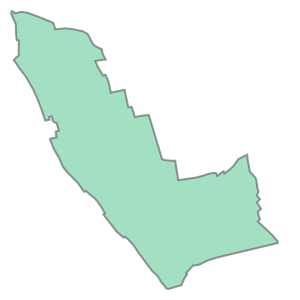

In [61]:
#so you should union all LSOA zones to get the boundary of the entire zone. check 
the_boundary = the_borough.unary_union
the_boundary

'the_boundary' is just a polygon object, we have to convert it to GeoSeries, then save to shapefile.

In [62]:
outline = gpd.GeoSeries(the_boundary)
outline.plot()

In [79]:
outline.to_file(os.path.join('output', 'boundary.shp'))

Remember that we have converted raster data into pandas dataframe. see below. If you treat the (x,y) as coordinates in 2D, you actucally, converted the raster data into a vector data set, with each grid represented by a point.

In [50]:
import georasters as gr
import os

In [51]:
#import the airqality file just downloaded from your local folder
rasterpath = os.path.join('data','2013_Met2013_LAEI2013_PM25.asc')

# Load data
rasterdata = gr.from_file(rasterpath)

In [52]:
raster_df = rasterdata.to_pandas()
raster_df.head(3)

,row,col,value,x,y
0,0,881,14.5353,"519,070.0000","203,450.0000"
1,0,882,14.5129,"519,090.0000","203,450.0000"
2,0,883,14.5110,"519,110.0000","203,450.0000"


Just to give you an illustration, we plot out part of the data. (The full data sets contains 5856428 points. Plotting the whole data sets will run for quite a long time)

In [56]:
raster_df.describe()

,row,col,value,x,y
count,"5,856,428.0000","5,856,428.0000","5,856,428.0000","5,856,428.0000","5,856,428.0000"
mean,"1,244.8809","1,391.9581",15.2763,"529,289.1613","178,552.3812"
std,645.7128,740.9007,0.8763,"14,818.0130","12,914.2560"
min,0.0000,0.0000,14.0315,"501,450.0000","152,350.0000"
25%,703.0000,768.0000,14.6570,"516,810.0000","167,910.0000"
50%,"1,225.0000","1,389.0000",15.0974,"529,230.0000","178,950.0000"
75%,"1,777.0000","2,010.0000",15.6463,"541,650.0000","189,390.0000"
max,"2,555.0000","3,026.0000",33.7233,"561,970.0000","203,450.0000"


In [59]:
raster_df_sel = raster_df.loc[(raster_df.row < 200) & (raster_df.col > 2000)]
raster_df_sel.plot.scatter(x='x', y='y', c = 'value')
plt.savefig('output/raster_data.png')

Ok, now we are going to get all points within the borough boundary. 

To improve the efficiency, we will do a two step process - 

- step 1 select points in bounding box - a very simple polygon composed by only four line segments

- step 2 spatial join the selected points with borough boundary - comparatively complicated polygon


**Think about why we do it in two steps!**

In [63]:
outline = gpd.read_file(os.path.join('output', 'boundary.shp'))
outline_bounds = outline.geometry.bounds # you get the bounding box of ken_sdf

In [64]:
outline_bounds

,minx,miny,maxx,maxy
0,"522,964.5807","176,948.6617","528,549.6785","182,764.7440"


So easy, we even do not have to do spatial join. Just select by values. 

In [65]:
raster_df_sel = raster_df.loc[((raster_df.x >= 522964.5807) & (raster_df.x <= 528549.6785)) & ((raster_df.y >= 176948.6617)&(raster_df.y <=182764.7440))]

In [66]:
#check if the number of points has been greatly reduced.
print('the numebr of points in raster_df is %d' %len(raster_df))
print('the numebr of points in raster_df_sel is %d' %len(raster_df_sel))

the numebr of points in raster_df is 5856428
the numebr of points in raster_df_sel is 81189


Ok, to perform a spatial join in second step, we have to generate spatial data from raster_df.x and raster_df.y. You have done that before in Practial 2.

In [76]:
raster_df_sel['geometry'] = raster_df_sel.apply(lambda loc: Point((float(loc.x), float(loc.y))), axis=1)
raster_df_sel = gpd.GeoDataFrame(raster_df_sel, geometry='geometry')
raster_df_sel.crs= "init: epsg:27700"

In [68]:
outline.crs = "init: epsg:27700"

In [69]:
print(raster_df_sel.crs)

init: epsg:27700


In [73]:
outline.plot()

In [74]:
raster_df_sel.plot()

plt.savefig('output/raster.png')

In [93]:
raster_df_sel.head(5)

,row,col,value,x,y,geometry
2418271,1035,1076,17.0011,"522,970.0000","182,750.0000",POINT (522970.000 182750.000)
2418272,1035,1077,17.9470,"522,990.0000","182,750.0000",POINT (522990.000 182750.000)
2418273,1035,1078,18.9797,"523,010.0000","182,750.0000",POINT (523010.000 182750.000)
2418274,1035,1079,19.0049,"523,030.0000","182,750.0000",POINT (523030.000 182750.000)
2418275,1035,1080,19.0069,"523,050.0000","182,750.0000",POINT (523050.000 182750.000)


In [90]:
#perform the spatial join - select all points fall in the boundary of the borough
pm25_in_borough = gpd.sjoin(raster_df_sel, outline, how="inner", op='within')

In [91]:
len(pm25_in_borough)

30348

In [96]:
pm25_in_borough.head(5)

,row,col,value,x,y,geometry,index_right,id
2418272,1035,1077,17.9470,"522,990.0000","182,750.0000",POINT (522990.000 182750.000),0,0
2418273,1035,1078,18.9797,"523,010.0000","182,750.0000",POINT (523010.000 182750.000),0,0
2420966,1036,1076,16.3002,"522,970.0000","182,730.0000",POINT (522970.000 182730.000),0,0
2420967,1036,1077,16.3781,"522,990.0000","182,730.0000",POINT (522990.000 182730.000),0,0
2420968,1036,1078,16.4739,"523,010.0000","182,730.0000",POINT (523010.000 182730.000),0,0


In [97]:
pm25_in_borough.plot(cmap = 'gist_earth', column='value')

plt.savefig('output/pm25_borough.png')

In [99]:
#finally, what the average PM25 in this borough?
pm25_in_borough.value.mean()

17.12686

## Further explore: Raster data in GDAL




Just for your interests, though georasters provides well-wrapped and easy to use functions. GDAL is more powerful, and gives you the flexiblity to manipulate data. 

So, we will use gdal package to load raster file. With GDAL, you can read and write several different raster formats in Python. Python automatically registers all known GDAL drivers for reading supported formats when the importing the GDAL module. 
Most common file formats include for example TIFF and GeoTIFF, ASCII Grid and Erdas Imagine .img -files. read more [here](https://automating-gis-processes.github.io/2016/Lesson7-read-raster.html).

In [98]:
from osgeo import gdal

filepath  = os.path.join('data', 'pm25_tiff.tif')

# Open the file:
airquality = gdal.Open(filepath)


# Check type of the variable 'raster'
type(airquality)

osgeo.gdal.Dataset

In [99]:
print('The properties of the file:')
print('The number of rows in the raster file is %d' %airquality.RasterXSize)
print('The number of columns in the raster file is %d' %airquality.RasterYSize)
print('The number of bands of the raster file is %d' %airquality.RasterCount)
print('The projection of the raster file is %s' %airquality.GetProjection())

The properties of the file:
The number of rows in the raster file is 3027
The number of columns in the raster file is 2556
The number of bands of the raster file is 1
The projection of the raster file is 


We mentioned in the Lecture that **raster data model allows NULL value**. The '[No Data Value]' are actually null value in the raster data. 

In [100]:
rasterArray = airquality.ReadAsArray()

In [101]:
rasterArray

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [103]:
band = airquality.GetRasterBand(1)
# Get nodata value from the GDAL band object
nodata = band.GetNoDataValue()

#Create a masked array for making calculations without nodata values
rasterArray = np.ma.masked_equal(rasterArray, nodata)
type(rasterArray)

# Check again array statistics, the minimum value of rasterArray
rasterArray.min()

numpy.ma.core.MaskedArray

In [107]:
rasterArray

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [110]:
## Get bounding box
width = airquality.RasterXSize    
height = airquality.RasterYSize
gt = airquality.GetGeoTransform()
minx = gt[0]   
miny = gt[3] + width * gt[4] + height * gt[5]    
maxx = gt[0] + width * gt[1] + height * gt[2]    
maxy = gt[3]

## Get elevation
band = airquality.GetRasterBand(1)

## Set NaNs 
pmdata = band.ReadAsArray()
noDataValue = band.GetNoDataValue()
pmdata[pmdata == noDataValue] = np.nan

## Plot it using matplotlib.pyplot
plt.imshow(pmdata, cmap = 'gist_earth', extent = [minx, maxx, miny, maxy])
plt.savefig('output/pm25.png')

## Credits

#### Contributors:
The following individuals have contributed to these teaching materials: Yijing Li (yijing.li@kcl.ac.uk), Jon Reades (jonathan.reades@kcl.ac.uk), Chen Zhong (chen.zhong@kcl.ac.uk)

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).